# Exploratory Data Analysis

In order to understand customer and seller interactions through Olist, we will perform an analysis of customer purchases over time. Our questions of interest will revolve around profit, products and reviews. We want to know what products produce the most income and are bought most frequently. We also want to know which are highest rated and if there is a seasonal correlation to customer satisfaction. Since our end goal is to create a recommendation system, understanding the product options and customer experience will help us know what features are most important for recommendations. 

The exploratory analysis below was performed using personalized graphing functions found in the functions folder and imported as "graphing".

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.offline
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
sns.set()

In [95]:
seller_dt_cols = ['shipping_limit_date', 'review_creation_date', 'review_answer_timestamp']
customer_dt_cols = ['shipping_limit_date', 'review_creation_date', 'review_answer_timestamp', 'order_purchase_timestamp',\
                'order_delivered_customer_date', 'order_estimated_delivery_date']

customers = pd.read_csv('modified_data/customers.csv', 
                        index_col=0, delimiter = ',', 
                        parse_dates = customer_dt_cols, 
                        infer_datetime_format = True, 
                        low_memory=False)
sellers = pd.read_csv('modified_data/sellers.csv', 
                      index_col=0, delimiter = ',', 
                      parse_dates = seller_dt_cols, 
                      infer_datetime_format = True, 
                      low_memory=False)

### Which product type generated the most profit?

In [96]:
def filter_by_count(df, column, count):
    
    new_df = df.groupby(column).filter(lambda x: len(x) > count)
    
    return new_df

In [285]:
def plot_filtered_groupby(title, df, groupby_col, sort_col, min_count, agg_func = sum, count = False, size = (10, 8)):
    
    if count == False:
        df_filtered = filter_by_count(df, groupby_col, min_count)\
                             [[groupby_col, sort_col]]\

        df_agg = df_filtered.groupby([groupby_col])[sort_col]\
                            .apply(agg_func)\
                            .reset_index()\
                            .sort_values([sort_col], ascending = False)
    else:
        df_filtered = filter_by_count(df, groupby_col, min_count)\
                                    [groupby_col].reset_index()
    
        df_agg = df_filtered.groupby([groupby_col])\
                                          .count()\
                                          .sort_values([sort_col], ascending = False)\
                                          .reset_index()
    
    fig, ax = plt.subplots(figsize=size)
    ax.set_title(title, fontsize=16)
    ax = sns.barplot(data=df_agg, x=sort_col, y=groupby_col, color = 'cyan')
    plt.show()

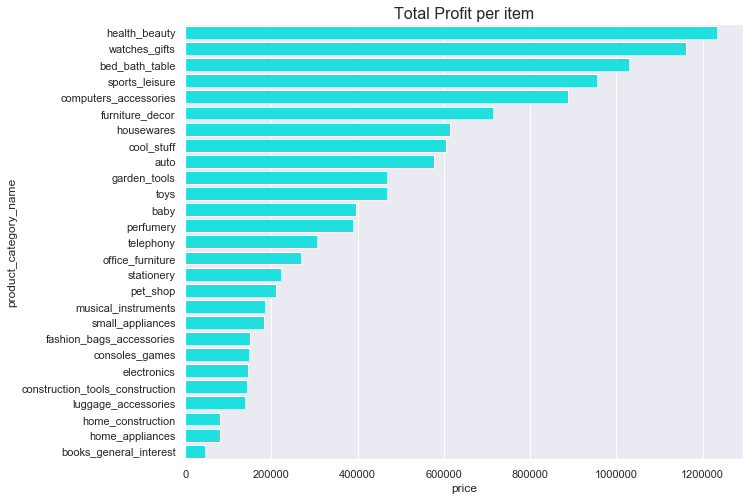

In [381]:
# group by the category column and limit the products to the ones that were bought at least 500 times
plot_filtered_groupby("Total Profit per item", customers, 'product_category_name', 'price', 500, sum)

> It looks like heath and beauty, watches, bed and bath, sports leisure and computer accessories round out the top 5 most profittable product categories. There are 11 items that grossed more than 400k over the approximately 2 year time span the data covers. 

### Which products are purchased most frequently?

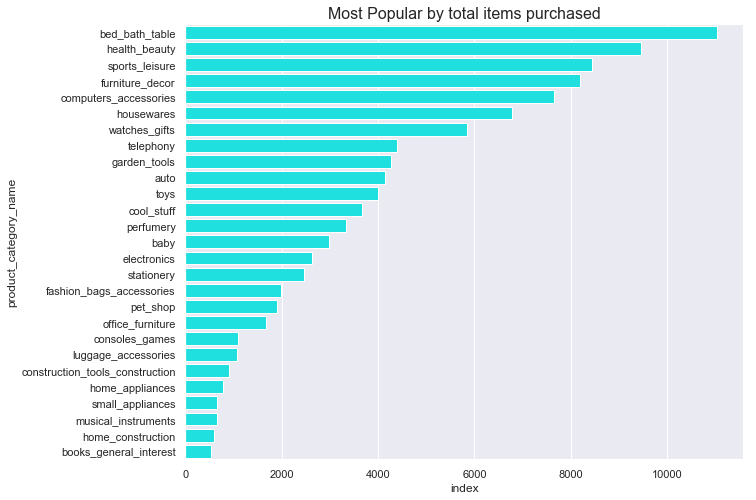

In [379]:
plot_filtered_groupby("Most Popular by total items purchased", customers, 'product_category_name', 'index', 500, count = True)

> The most frequently bought items generally correlate well with the highest grossing products. Watches and gifts fall out of the top 5 which implies the items on average must be relatively high. Sports leasure is the third highest purchased item but is not in the top 5 highest grossing items, implying that average cost may be lower relative to the majority. 

### Which product has the highest average cost for the customer?

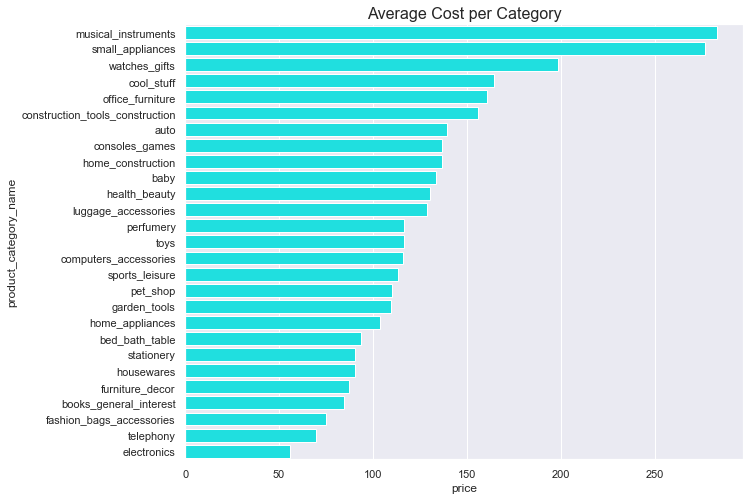

In [289]:
plot_filtered_groupby("Average Cost per Category", customers, 'product_category_name', 'price', 500, np.mean)

> Not suprizingly we see that watches and gifts are in the top 5 most costly items, with sports and leisure items falling out of the top 15 most costly items, confirming former assumptions. Musical Instruments, small appliances and watches and gifts are the most costly categories. One interesting finding is that watches and gifts and auto products are the only two groups that fit into the top 10 for cost, profit and most frequently bought.  

### What are the highest rated products?

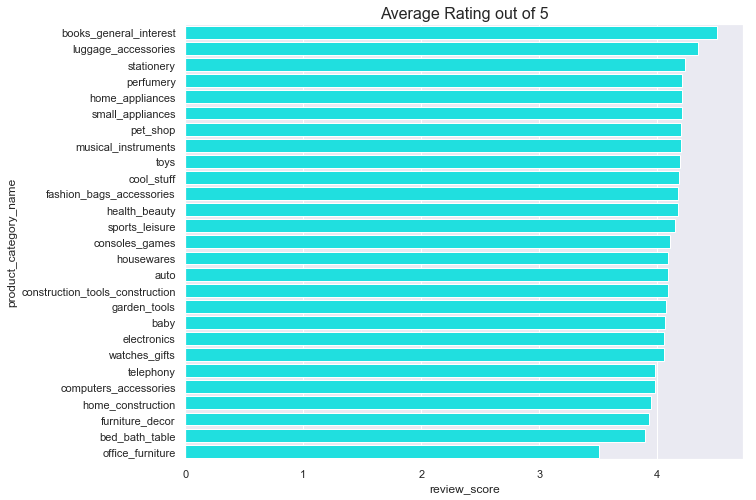

In [298]:
plot_filtered_groupby("Average Rating out of 5", customers, 'product_category_name', 'review_score', 500, np.mean)

> It looks like many of the highest grossing products fall on the lower end of the average review score with the exception of health and beauty, and sports leisure. Small appliances is highly rated and has a high average cost, but this is a category that falls on the lower end for gross profit and number of times purchased. 

## Exploring Seasonal Trends

For this analysis we will switch to a yearly view starting from July of 2017 to July of 2018. Olist during 2017 was still growing, making themselves much more widely known on black friday of 2017. The growth in sales during the period noted will give a better picture of yearly trends for their growth after this point. For each of the plots below the aggregations are made using the day and time the item was purchased, as opposed to when it was delivered or noted in the system. This will give us a better perspective of the customer and for us to note any seasonal purchase trends.

### When is Olist receiving the most profit?

In [342]:
def timeseries_plot(title, df, timeseries_col, y_col, dStart, dEnd, agg_func = sum, count = False, sample_by = 'D', axvline=[np.nan], size = (12, 6)):
    
    if count == True:
        timeseries_vs_y = df[[timeseries_col, y_col]]
        plot_df = timeseries_vs_y.set_index(timeseries_col).resample(sample_by)[y_col].count()
        df = plot_df[(dStart <= plot_df.index) & (plot_df.index <= dEnd)]
    
    else:
        timeseries_vs_y = df[[timeseries_col, y_col]]
        plot_df = timeseries_vs_y.set_index(timeseries_col).resample(sample_by)[y_col].apply(agg_func)
        df = plot_df[(dStart <= plot_df.index) & (plot_df.index <= dEnd)]

    ax = plt.figure(figsize=size).add_subplot(111)   
    xticks = pd.date_range(start=dStart, end=dEnd, freq='M')

    df.plot(ax = ax, xticks = xticks)
    
    for axv in axvline:
        ax.axvline(axv, color='r', linestyle='--', lw=1)
    
    ax.set_title(title, fontsize=16)
    ax.set_xticklabels([x.strftime('%h%d\n%Y') for x in xticks])
    plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
 
    plt.show()

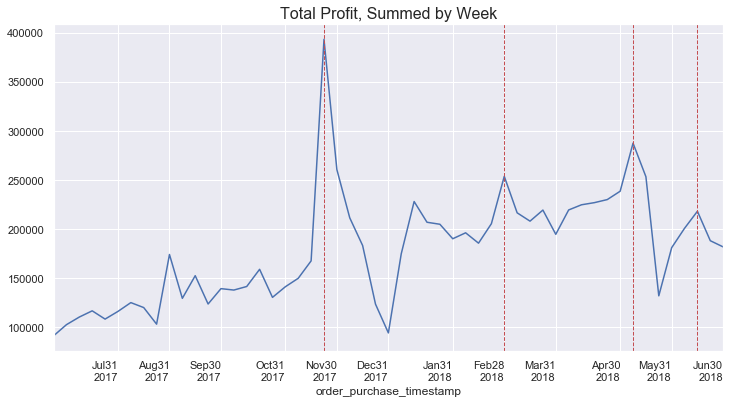

In [382]:
dStart = datetime.datetime(2017,7,1) # 1 July 2017
dEnd = datetime.datetime(2018,7,1) # 1 July 2018
vline = [datetime.datetime(2017, 11,24), # 24th Novem "Black Friday"
         datetime.datetime(2018, 5,10), # 10th May 2018
         datetime.datetime(2018, 6,11), # 11th June 2018
         datetime.datetime(2018, 2,28)] # 28th Feb 2018
timeseries_plot('Total Profit, Summed by Week', 
                customers, 
                'order_purchase_timestamp', 
                'price',  
                dStart, 
                dEnd,
                sum,
                sample_by='W', 
                axvline = vline)

> There is a clear uptick for one day in 2017, this corresponded to "Black Friday" around the world and clearly was the cause of this jump in sales. There follows a drop with another uptick in early January. Sales seem to steadily increase from this point through to the summer months, where there is a peak in early May and mid June.

### How many products were they selling per week over the same period?

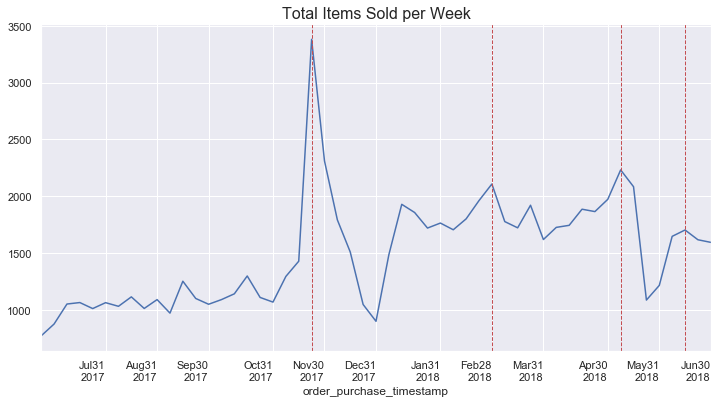

In [347]:
vline = [datetime.datetime(2017, 11,24), # 24th Novem "Black Friday"
         datetime.datetime(2018, 5,10), # 10th May 2018
         datetime.datetime(2018, 6,11), # 11th June 2018
         datetime.datetime(2018, 2,28)] # 28th Feb 2018
timeseries_plot('Total Items Sold per Week', 
                customers, 
                'order_purchase_timestamp', 
                'product_count',
                dStart, 
                dEnd,
                count=True,
                sample_by='W', 
                axvline = vline)

> What we can see is that after the black friday surge experienced on February 28th, there was a sharp drop in purchases but it is clear that they were able to aquire a larger customer base who returned to the website for more purchases beginning in early January.

### How do review scores change over time? Are there any seasonal trends?

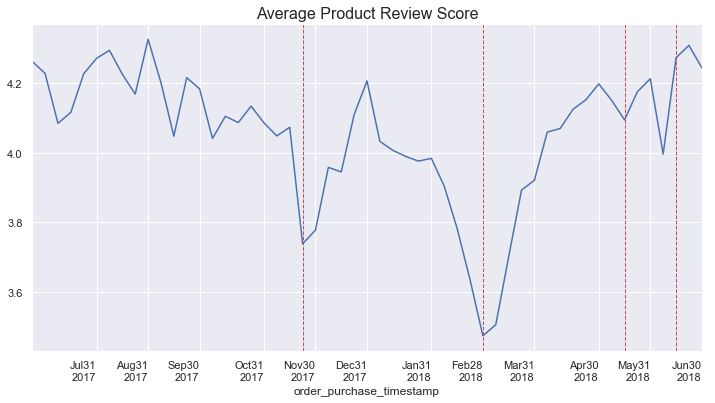

In [357]:
# Vertical lines marking dips in review
vline = [datetime.datetime(2017, 11, 24), # Corresponds with Black Friday
         datetime.datetime(2018, 2, 28), # corresponds with peak above 28th Feb 2018
         datetime.datetime(2018, 5, 14), # Drop in review score on 14th May, not corresponding to profit
         datetime.datetime(2018, 6,11) # Drop in review score on 5th June, not corresponding to profit
        ]
timeseries_plot('Average Product Review Score', 
                customers, 
                'order_purchase_timestamp', 
                'review_score',  
                dStart, 
                dEnd,
                np.mean,
                sample_by='W', 
                axvline = vline)

> The average review score drops during high volume purchasing periods. The vertical lines noted above correspond to the high volume period noted in the previous plot. There are two discrepencies however, on February 28th there is a minor increase in sales but this corresponds to an extremely large drop in review scores. Also, as can be seen in the plot above, the increase in sales in mid June does not correlate to the drop seen above earlier in the month. There may be some outlier cause here, or a seasonal challenge with delivery times that affects reviews that needs to be investigated further. 

### During what seasons are late delivery times the most significant? How does this affect customer satisfaction?

In [362]:
#customers[customers['order_delivered_customer_date'] > customers['order_estimated_delivery_date']].count()
customers['on_time'] = (customers['order_estimated_delivery_date']
                           >=
                        customers['order_delivered_customer_date'])

customers['diff_days'] = (customers['order_delivered_customer_date']
                             -
                          customers['order_estimated_delivery_date'])

customers['diff_days'] = customers['diff_days']/np.timedelta64(1, 'D')
customers['satisfied'] = (customers['review_score'] >= 3)
# Create product_count column for the rating

customers['product_count'] = customers['product_id']\
                                                    .groupby(customers['customer_unique_id'])\
                                                    .transform('count')

delivery_time = customers[['order_delivered_customer_date', 'order_estimated_delivery_date', 
                           'review_score', 'order_purchase_timestamp', 'satisfied', 'diff_days', 
                           'on_time', 'product_count', 'product_id', 'product_category_name']]

In [364]:
# isolate only the late deliveries
late_deliveries = delivery_time.loc[delivery_time['on_time'] == False]

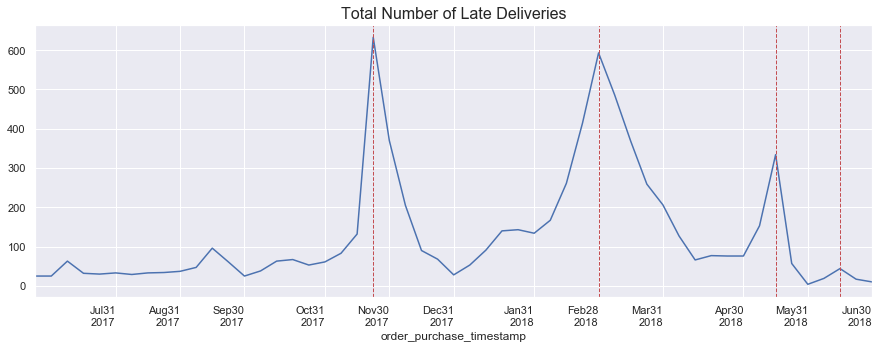

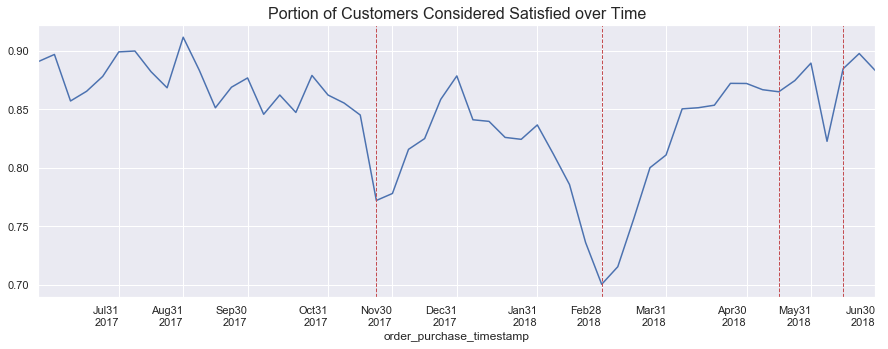

In [384]:
vline = [datetime.datetime(2017, 11,24), # 24th Novem "Black Friday"
         datetime.datetime(2018, 5,14), # 10th May 2018
         datetime.datetime(2018, 6,11), # 11th June 2018
         datetime.datetime(2018, 2,28)] # 28th Feb 2018
timeseries_plot('Total Number of Late Deliveries', 
                late_deliveries, 
                'order_purchase_timestamp', 
                'product_count',
                dStart, 
                dEnd,
                count=True,
                sample_by='W',
                axvline=vline, 
               size=(15,5))

timeseries_plot('Portion of Customers Considered Satisfied over Time', 
                delivery_time, 
                'order_purchase_timestamp', 
                'satisfied',
                dStart, 
                dEnd,
                np.mean,
                sample_by='W',
                axvline=vline, 
               size=(15,5))

> There is clearly a relationship between customer satisfaction and on-time delivery. The number of satisfied customers dip dramatically for the three main high volume periods. There is one dip on June 6th that is not accounted for however. This corresponds to the same dip seen in product review score, which is to be expected. This may be a date to investigate to see what kinds of products were bought and why customers may have been dissatisfied. 

> It is also clear now what is causing the dip in average product review scores identified previously on February 28th. Although this day had no where near the volume of orders seen on black friday, it had almost as many late deliveries on products ordered on this day.

### Investigating June 6th drop in customer satisfaction

In [374]:
# columns of interest
columns = ['order_purchase_timestamp', 'product_id', 'product_category_name', 
                'satisfied', 'review_score', 'diff_days', 'on_time']
# set min and max to encompass the entire day of june 4th
june_sixth = customers[(customers.order_purchase_timestamp >= datetime.datetime(2018, 6, 6)) \
                          & (customers.order_purchase_timestamp <= datetime.datetime(2018, 6, 7))]\
                            [columns]
feb_twentyeight = late_deliveries[(late_deliveries.order_purchase_timestamp >= datetime.datetime(2018, 2, 28)) \
                          & (late_deliveries.order_purchase_timestamp <= datetime.datetime(2018, 3, 1))]\
                            [columns]

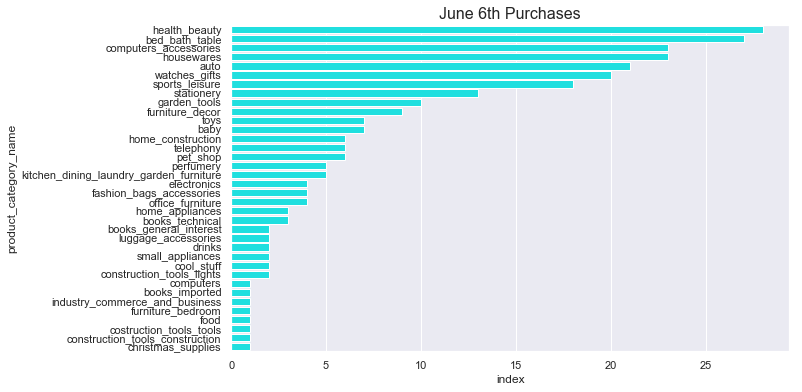

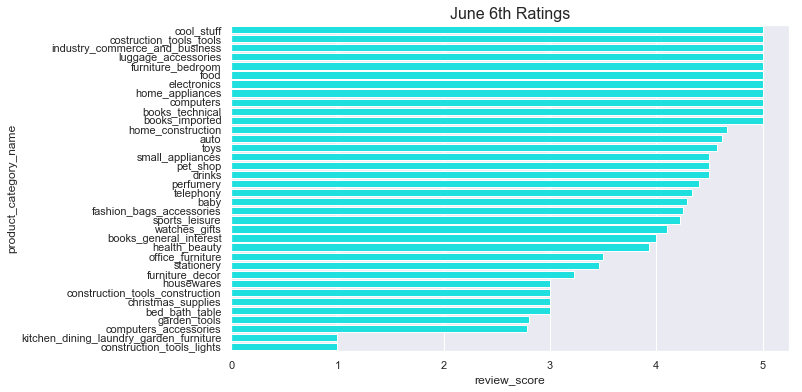

In [378]:
plot_filtered_groupby("June 6th Purchases", june_sixth, 'product_category_name', 'index', 0, count = True, size = (10, 6))
plot_filtered_groupby("June 6th Ratings", june_sixth, 'product_category_name', 'review_score', 0, np.mean, size = (10, 6))

> Suprizingly there were only 3 late items on June 6th, two of which were rated as unsatisfactory.

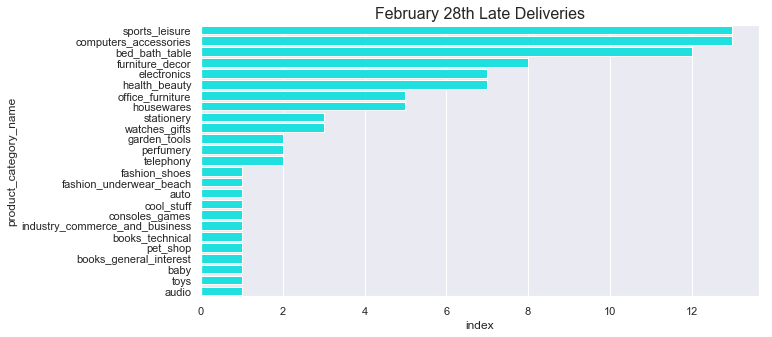

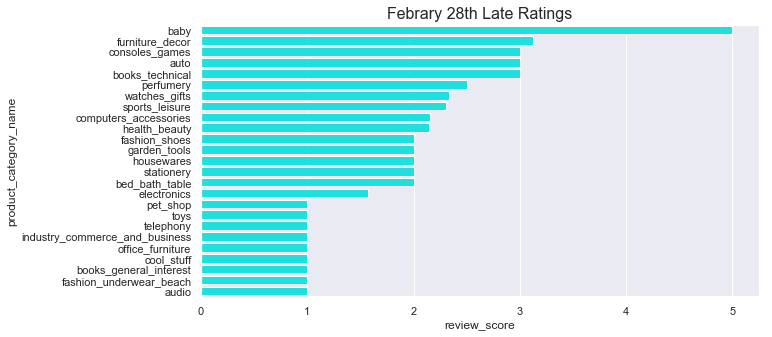

In [373]:
plot_filtered_groupby("February 28th Late Deliveries", feb_twentyeight, 'product_category_name', 'index', 0, count = True, size = (10, 5))
plot_filtered_groupby("Febrary 28th Late Ratings", feb_twentyeight, 'product_category_name', 'review_score', 0, np.mean, size = (10, 5))

> Many more items were delivered late on February 28th, many of which were rated at or below a 3, our satisfactory benchmark. Notebly, sports leasure and computer accessories made up most of the late deliveries but averaged below a 3 rating.

In [322]:
total = june_sixth.satisfied.count()
pct = np.mean(june_sixth.satisfied)
late_pct = np.mean(june_sixth.on_time)
print("Total number of purchases on June sixth: ")
print(total, "\n")
print("Percent of satisfied customers: \n{:.1f}%\n".format(pct*100))
print("Percent of on-time deliveries: \n{:.1f}%".format(late_pct*100))

Total number of purchases on June sixth: 
272 

Percent of satisfied customers: 
76.5%

Percent of on-time deliveries: 
98.9%


In [323]:
total = feb_twentyeight.satisfied.count()
pct = np.mean(feb_twentyeight.satisfied)
late_pct = np.mean(feb_twentyeight.on_time)
print("Total number of purchases on Feb 28th for comparison: ")
print(total, "\n")
print("Percent of satisfied customers: \n{:.1f}%\n".format(pct*100))
print("Percent of on-time deliveries: \n{:.1f}%".format(late_pct*100))

Total number of purchases on Feb 28th for comparison: 
352 

Percent of satisfied customers: 
70.5%

Percent of on-time deliveries: 
73.3%


> It appears that bed bath tables and housewares are the primary reason for a dip in reviews on June 4th in 2018. They were the top two items bought that day but were the among the worst rated. What should also be noted is that the percentage of on time deliveries was not correlated to the drop in reviews like many other instances. Almost all of the deliveries were on time, as compared to February 28th when less that 75% of packages were delivered on time.

## Summary from Exploratory Phase

Exploratory analysis revealed a number of interesting factors contributing to customer satisfaction. The strongest predictor was delivery time. We also found that many of the most popular categories were also some of the worst rated. While this could simply be because of the fact that the items were purchased more, leading to more chances for lower ratings to appear, there could be more contributing to lower ratings. After investigating a case study on June 6th, it was found that the same categories with lower ratings were recieving lower scores although the items were delivered on time. 

While customer satisfaction will not directly contribute our recommendation system, it does give us a sense of what Olist offers and what customers are buying most. The most popular categories were found to be bed bath, furniture decorations, sports leisure and computer accessories. These items will be some of the primary linkages between customers and how we recommend items. Another factor to be noted are the number of products that were not purchased at least 500 times within a year span. While there are 72 categories, only 27 were popular over that time frame. 

The challenges we face in creating our recommendation system will be with recommending items that may fit a customers purchasing habits but were not bought enough by others to be considered. To combat this our approach will rely on a hybrid approach, which takes into consideration not only what other customers bought, but also information about the user and the products they purchased. This will help combat a common problem for recommendation systems, which is the "cold start" issue that arises with new customers. For our purposes it will also help with the number of customers who purchased from Olist only once.